In [8]:
'''
__author__ = 'Alex Cheng'
惩罚线性回归模型 --- K折
Ridge回归通过对回归系数的平方和进行惩罚来避免过拟合(beta的平方和，L2)
其他惩罚项：Lasso(L1), ElasticNet(a)
Lasso的系数向量beta是稀疏的，即对不同的lambda值，许多稀疏等于0,
相比之下Ridge的向量beta是密集的，大部分不等于0

最小角度回归(LARS),可以理解为一种改进的前向逐步回归算法：在引入新属性时只是部分
生成变量重要性排序是惩罚线性回归模型的一个重要特征
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets,linear_model
from sklearn.metrics import roc_curve,auc
from math import sqrt

In [9]:
target_url3 = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
"wine-quality/winequality-red.csv")
df = pd.read_csv(target_url3,header=0,sep=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [10]:
xList  = np.array(df.iloc[:,:-1]) # 属性数组
labels = [i for i in df.iloc[:,-1]] # 最后一列就是label

# 将属性矩阵和标签向量2/3训练，1/3测试
#indices = len(df) # len表示df有多少行
#df.iloc[:,-1].value_counts() # M:111, R:97
#xTrain = np.array(df[df.index % 3 != 0].iloc[:,:-1]) # dataframe转为numpy数组
#yTrain = np.array([labels[i] for i in df.index if i%3 !=0])
#xTest =  np.array(df[df.index % 3 == 0].iloc[:,:-1])
#yTest = np.array([labels[i] for i in df.index if i%3 ==0])

In [11]:
# 正则化columns in x and labels
nrows = len(xList)
ncols = len(xList[0])

# 计算means and variance
xMeans = []
xSD = []
for i in range(ncols):
    col = [xList[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = sum((col - mean) **2)
    
    colDiff2 = [(xList[j,i] - mean) for j in range(nrows) ]
    sumSq = sum([colDiff2[i]  * colDiff2[i] for i in range(nrows)])
    stdDev2 = sqrt(sumSq/nrows)
    
    stdDev = sqrt(colDiff/nrows)
    xSD.append(stdDev)
#print(xMeans,'\n',xSD)
print(stdDev == stdDev2) # broadcast广播变量的方式，发现结果一样


# 正则化xList
xNorm = []
for i in range(nrows):
    #rowNorm = ([xList[i] - xMeans]) / xSD  #列表不支持
    rowNorm = [(xList[i,j] - xMeans[j]) / xSD[j] for j in range(ncols)]
    xNorm.append(rowNorm)

# 正则化 labels
meanLable = sum(labels)/ nrows
sdLabel = sqrt(sum([ (labels[i] - meanLable) * (labels[i] - meanLable) for i in range(nrows)]) / nrows)
labelNorm = [ (labels[i] - meanLable) / sdLabel for i in range(nrows) ]


True


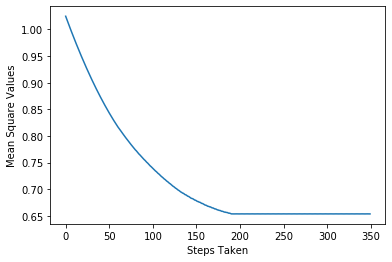

In [12]:
# 从数百个LARS生成结果中选择最佳模型
# 利用10折交叉验证来确定最佳系数集合

#xList  = np.array(df.iloc[:,:-1]) # 属性数组
#labels = [i for i in df.iloc[:,-1]] # 最后一列就是label
xNorm,labelNorm # 正则化以后的x,y
nxval = 10
steps = 350
stepSize = 0.004

errors = []
for i in range(steps):
    b = []
    errors.append(b)

for ixval in range(nxval):
    # Define test and traing index sets
    idxTest =  [i for i in range(nrows) if i % nxval == ixval*nxval]
    idxTrain = [i for i in range(nrows) if i % nxval != ixval*nxval]
    pass
idxTest =  [i for i in range(nrows) if i % nxval ==0]
idxTrain = [i for i in range(nrows) if i % nxval !=0]

# 定义测试和训练的属性和列表
xTrain = [xNorm[r] for r in idxTrain]
xTest  = [xNorm[r] for r in idxTest]
yTrain = [labelNorm[r] for r in idxTrain]
yTest  = [labelNorm[r] for r in idxTest]


# 训练LARS回归
nrowsTrain = len(idxTrain)
nrowsTest  = len(idxTest)

# 初始化 coefficients beta向量
beta = [0.0] * ncols

# 初始化 matrix of beta at each step
betaMat = []
betaMat.append(list(beta))


for step in range(steps):
    residuals = [0.0] * nrowsTrain # 全体记录数？?
    for j in range(nrowsTrain): # 计算训练集的预测的残差
        labelsHat = sum([xTrain[j][k] * beta[k] for k in range(ncols)])
        residuals[j] = yTrain[j] - labelsHat
    
    # 计算每个列（属性）和残差的相关性
    corr = [0.0] * ncols
    for j in range(ncols):
        corr[j] = sum([xTrain[k][j] * residuals[k] for k \
                       in range(nrowsTrain)]) / nrowsTrain
    
    iStart = 0
    corrStart = corr[0]
    for j in range(1,ncols): #找绝对值最大的系数
        if abs(corrStart) < corr[j]:
            iStart = j; corrStart = corr[j]
            
    beta[iStart] += stepSize * corrStart / abs(corrStart) # 对应beta值增加
    betaMat.append(list(beta)) # 这个步骤的beta系数
    
    # 使用最新的beta系数预测测试接的错误
    for j in range(nrowsTest):
        labelsHat = sum([xTest[j][k] * beta[k] for k in range(ncols)])
        err = yTest[j] - labelsHat
        errors[step].append(err)

cvCurve = []
for err in errors:
    mse = sum([x*x for x in err]) / len(err)
    cvCurve.append(mse)

minMse = min(cvCurve)
minPt = [i for i in range(len(cvCurve)) if cvCurve[i] == minMse] # 最小错误的step

xaxis = range(len(cvCurve))
plt.plot(xaxis,cvCurve)
plt.xlabel('Steps Taken')
plt.ylabel('Mean Square Values')
plt.show()      